# Imports

In [1]:
import os, sys

parent = os.path.abspath('..')
sys.path.insert(1, parent)

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from darts import TimeSeries
from helper_funcs.preprocessing import market_init
from helper_funcs.data import cleaned_market
import matplotlib.pyplot as plt
import ta
import pandas_ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
# scaler = StandardScaler()

EXP_MA = 15

# Data sentiment

In [3]:
df_sentiment = pd.read_pickle("../../Project_Files/Preprocessed_Files/sentiment/sentiment_finetuned.pkl")
tickers_df = pd.read_csv("../../Datasets/kaggle/Company_Tweet.csv")

df_sentiment contains 1 or 0 as positive/negative sentiment for tweet obtained using this pretrianed model: https://huggingface.co/zhayunduo/roberta-base-stocktwits-finetuned

In [4]:
df_sentiment.head()

,tweet_id,post_date,body,preprocessed,interactions,sentiment_score
0,550441509175443456,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx madeon check it out! learn #howtotrade,1,0
1,550441672312512512,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...,0,0
2,550441732014223360,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,s&p #stocks performance more@,0,1
3,550442977802207232,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes record recall tally higher,1,0
4,550444969924653056,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,apple goes global with 'start something new' a...,1,1


tickers_df maps tweet id to the company the tweet is about

In [5]:
tickers_df.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [6]:
df_sentiment = df_sentiment.merge(tickers_df, on='tweet_id', how='inner')
df_sentiment = df_sentiment[['post_date', 'sentiment_score', 'ticker_symbol']]
df_sentiment

,post_date,sentiment_score,ticker_symbol
0,2015-01-01 00:00:57,0,AAPL
1,2015-01-01 00:01:36,0,AAPL
2,2015-01-01 00:01:50,1,AMZN
3,2015-01-01 00:06:47,0,TSLA
4,2015-01-01 00:14:42,1,AAPL
...,...,...,...
2777220,2019-12-31 23:51:06,1,AAPL
2777221,2019-12-31 23:53:03,1,AAPL
2777222,2019-12-31 23:53:21,0,TSLA
2777223,2019-12-31 23:54:03,0,TSLA


# Data price

In [7]:
market = market_init()

In [8]:
market

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Return,Volatility
0,2015-01-01,AAPL,24.839497,27.594999,28.282499,27.552500,28.205000,1.581289e+08,0.000000,0.651332
1,2015-01-01,AMZN,15.517500,15.517500,15.649000,15.500500,15.577500,6.247780e+07,0.000000,0.354609
2,2015-01-01,GOOG,26.247936,26.247936,26.557089,26.218018,26.489773,3.485041e+07,0.000000,0.433642
3,2015-01-01,GOOGL,26.533001,26.533001,26.920000,26.510000,26.886999,3.903128e+07,0.000000,0.458219
4,2015-01-01,MSFT,40.540867,46.450001,47.439999,46.450001,46.730000,2.329327e+07,0.000000,0.894928
...,...,...,...,...,...,...,...,...,...,...
7819,2019-12-31,AMZN,92.391998,92.391998,92.663002,91.611504,92.099998,6.628262e+07,0.000514,1.255874
7820,2019-12-31,GOOG,66.850998,66.850998,66.900002,66.454247,66.505501,2.240515e+07,0.000659,0.715587
7821,2019-12-31,GOOGL,66.969498,66.969498,67.032997,66.606499,66.789497,2.360733e+07,-0.000239,0.715739
7822,2019-12-31,MSFT,153.313141,157.699997,157.770004,156.449997,156.770004,1.945888e+07,0.000698,1.558165


In [ ]:
# market = pd.DataFrame([])
# for i in range(6):
#     df = timeseries[i].pd_dataframe().reset_index()
#     df['Ticker'] = timeseries[i].static_covariates_values()[0][0]
#     df['Volatility'] = ta.volatility.AverageTrueRange(
#         high=df.High, low=df.Low, close=df.Close, window=EXP_MA
#     ).average_true_range()
#     market = pd.concat([market, df], axis=0)

# Processing sentiment

Using groupby to count negative and positive sentiment values for each day and each company

In [9]:
df_sentiment.loc[:, 'post_date'] = df_sentiment.post_date.apply(lambda x: x.to_pydatetime().date())
df_sentiment = df_sentiment.groupby(['ticker_symbol', 'post_date']).value_counts().unstack(fill_value=0)

### Calculating sentiment score and it's moving average

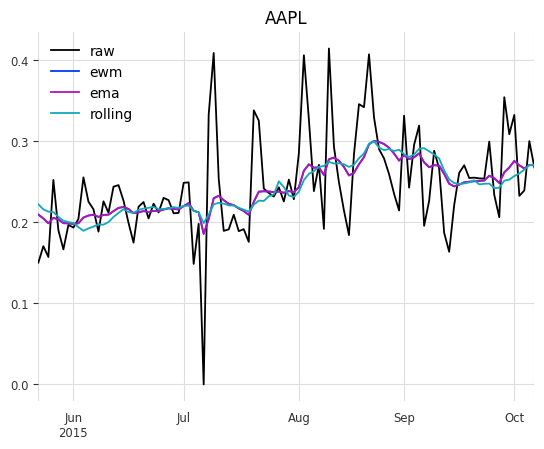

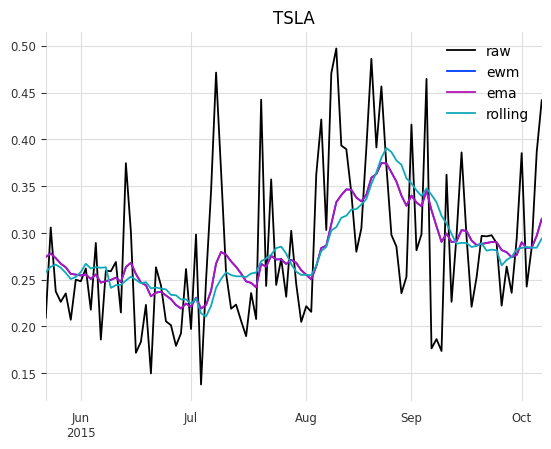

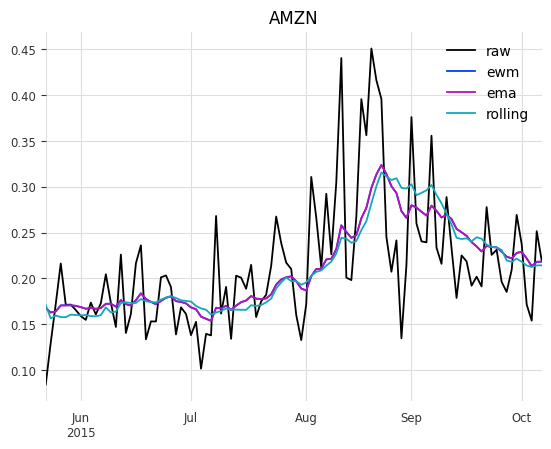

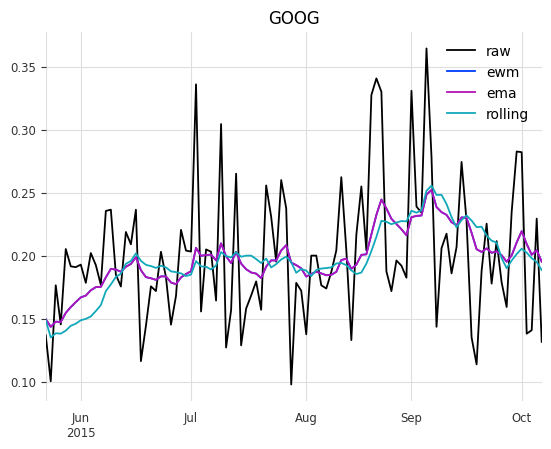

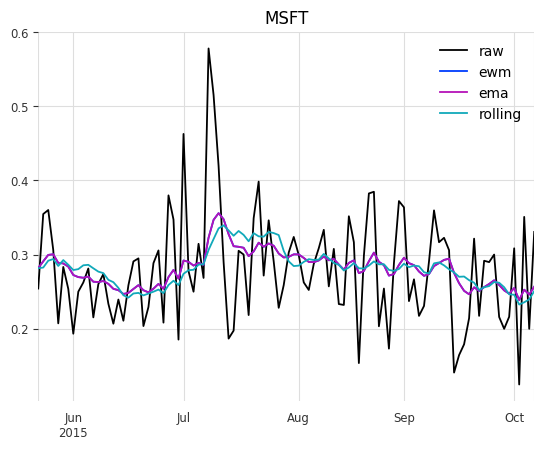

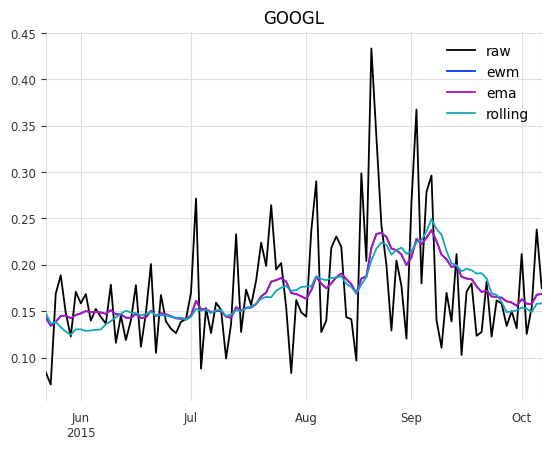

In [12]:
sentiment_dict = dict()
tickers = tickers_df.ticker_symbol.value_counts().index.to_list()

# fraction of negative tweets in all tweets
def frac_by_all(negative, positive):
    if negative == 0:
        return 0
    return negative / (negative + positive)

def frac(negative, positive):
    if negative == 0:
        return 0
    return negative / positive

for ticker in tickers:
    # first we add missing dates and fill thew with 0
    company = df_sentiment.xs(ticker).reindex(pd.date_range('2015-01-01', '2019-12-31'), fill_value=0)

    # then resample to business days and add up dropped past values up to the date that is not dropped
    company = company.resample(rule="B", origin='end').sum().rename(columns = {0:'Negative', 1:'Positive'})

    # taking fractions of negative tweeets to calculate the final score 
    company['sentiment_score_1'] = company.apply(lambda row: frac_by_all(row['Negative'], row['Positive']), axis=1)
    company['sentiment_score_2'] = company.apply(lambda row: frac(row['Negative'], row['Positive']), axis=1)

    # visualize different approaches
    company.sentiment_score_1[100:200].plot(label='raw')
    company.sentiment_score_1.ewm(span=EXP_MA).mean()[100:200].plot(label='ewm')
    pandas_ta.ema(company.sentiment_score_1, length=EXP_MA)[100:200].plot(label='ema')
    company.sentiment_score_1.rolling(EXP_MA).mean()[100:200].plot(label='rolling')
    plt.title(ticker)
    plt.legend()
    plt.show()

    # calculating moving average
    company['sentiment_score_1'] = company.sentiment_score_1.ewm(span=EXP_MA).mean()
    company['sentiment_score_2'] = company.sentiment_score_2.ewm(span=EXP_MA).mean()

    company['ticker'] = ticker
    sentiment_dict[ticker] = company

In [ ]:
# data = pd.DataFrame([])
# for i in range(6):
#     df = timeseries[i].pd_dataframe().reset_index()
#     df['Ticker'] = timeseries[i].static_covariates_values()[0][0]
#     data = pd.concat([data, df], axis=0)

# Comparison

During the comparison you can observe high correlation of Volatility for the stock price and Sentiment score that is nearly 60 percent in all cases except microsoft.

First we compare raw values, then MinMax scaled for better visualization

**MOVING AVERAGE = 15** (3 business weeks NYSE works 5 days a week)

**sentiment_score_1 = negative / (negative + positive)**  <---- better correlation values


**sentiment_score_2 = negative / positive**

In [13]:
def comparison(ticker):
    close = market[market.Ticker == ticker].set_index('Date').Close
    volume = market[market.Ticker == ticker].set_index('Date').Volume.ewm(span=EXP_MA).mean()
    volume = market[market.Ticker == ticker].set_index('Date').Volume
    sent_1 = sentiment_dict[ticker].sentiment_score_1
    sent_2 = sentiment_dict[ticker].sentiment_score_2
    atr = market[market.Ticker == ticker].set_index('Date').Volatility
    df  = pd.concat([close, volume, sent_1, sent_2, atr], axis=1).dropna()
    return df

## Apple

In [50]:
df = comparison('AAPL')
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [51]:
df[['Close', 'Volume', 'Volatility', 'sentiment_score_1']].rename(columns={
    'sentiment_score_1': 'Sentiment score'
}).corr()

,Close,Volume,Volatility,Sentiment score
Close,1.000000,-0.511193,0.614700,0.199375
Volume,-0.511193,1.000000,0.104378,0.200569
Volatility,0.614700,0.104378,1.000000,0.686611
Sentiment score,0.199375,0.200569,0.686611,1.000000


In [52]:
df.corr()

,Close,Volume,sentiment_score_1,sentiment_score_2,Volatility
Close,1.000000,-0.511193,0.199375,0.180913,0.614700
Volume,-0.511193,1.000000,0.200569,0.207550,0.104378
sentiment_score_1,0.199375,0.200569,1.000000,0.994332,0.686611
sentiment_score_2,0.180913,0.207550,0.994332,1.000000,0.684632
Volatility,0.614700,0.104378,0.686611,0.684632,1.000000


In [16]:
# print(df[['Close', 'Volume', 'Volatility', 'sentiment_score_1']].rename(columns={
#     'sentiment_score_1': 'Sentiment score'
# }).corr().to_latex())

# df[['Close', 'Volume', 'Volatility', 'sentiment_score_1']].rename(columns={
#     'sentiment_score_1': 'Sentiment score'
# }).corr()

,Close,Volume,Volatility,Sentiment score
Close,1.000000,-0.511193,0.614700,0.199375
Volume,-0.511193,1.000000,0.104378,0.200569
Volatility,0.614700,0.104378,1.000000,0.686611
Sentiment score,0.199375,0.200569,0.686611,1.000000


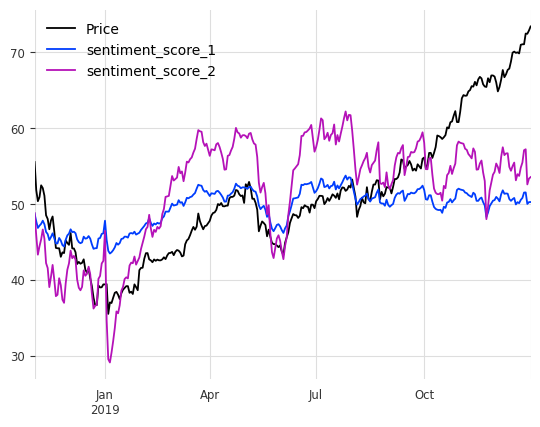

In [17]:
df.Close[1000:].plot(label='Price')
((1 - (df.sentiment_score_1[1000:])) * 70).plot(label='sentiment_score_1')
((1 - (df.sentiment_score_2[1000:])) * 90).plot(label='sentiment_score_2')
plt.legend();

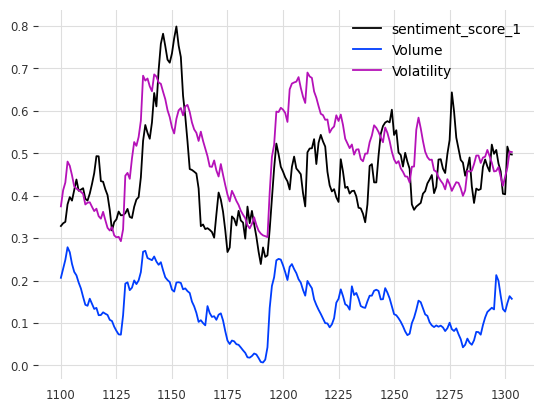

In [18]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][1100:].plot();

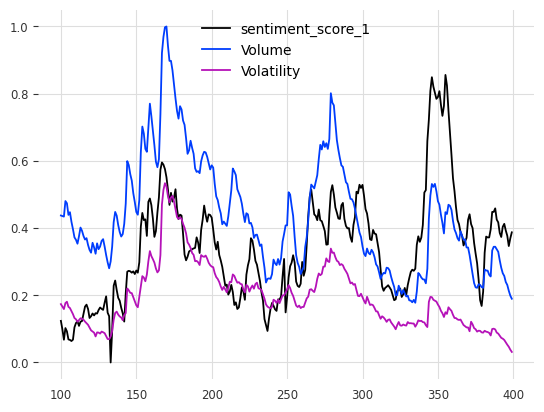

In [19]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][100:400].plot();

/home/andrei/miniconda3/envs/hse/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


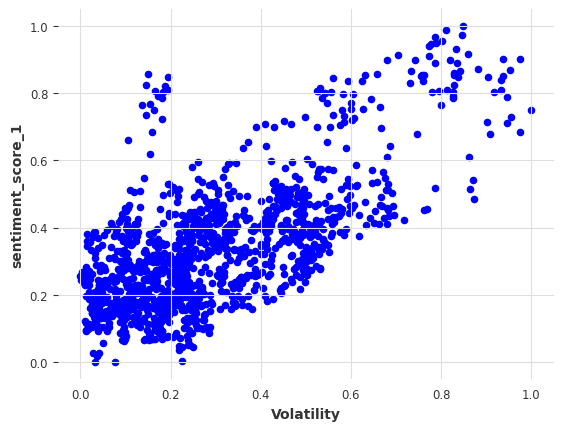

In [20]:
df_scaled.plot.scatter(x='Volatility', y='sentiment_score_1', c='b');

## Microsoft

In [21]:
df = comparison('MSFT')
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [22]:
df.corr()

,Close,Volume,sentiment_score_1,sentiment_score_2,Volatility
Close,1.000000,-0.353357,0.079394,0.075990,0.726132
Volume,-0.353357,1.000000,0.269791,0.250354,0.224234
sentiment_score_1,0.079394,0.269791,1.000000,0.994544,0.304180
sentiment_score_2,0.075990,0.250354,0.994544,1.000000,0.291922
Volatility,0.726132,0.224234,0.304180,0.291922,1.000000


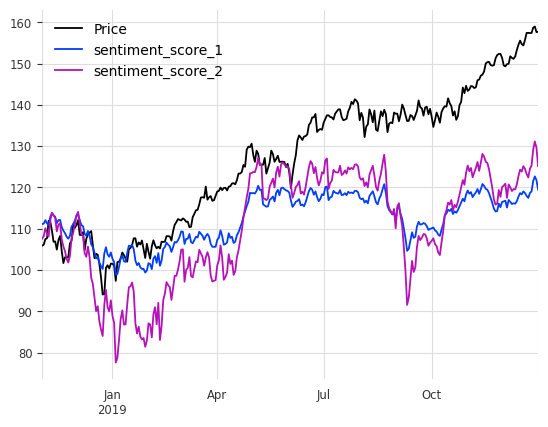

In [24]:
df.Close[1000:].plot(label='Price')
((1 - (df.sentiment_score_1[1000:])) * 150).plot(label='sentiment_score_1')
((1 - (df.sentiment_score_2[1000:])) * 170).plot(label='sentiment_score_2')
plt.legend();

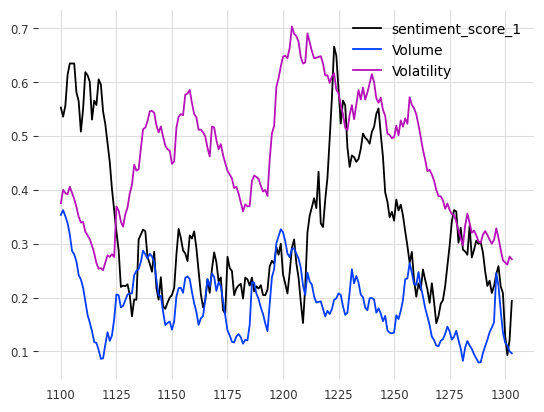

In [25]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][1100:].plot();

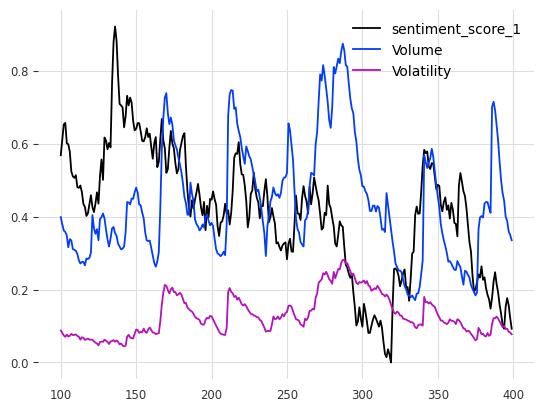

In [26]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][100:400].plot();

/home/andrei/miniconda3/envs/hse/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


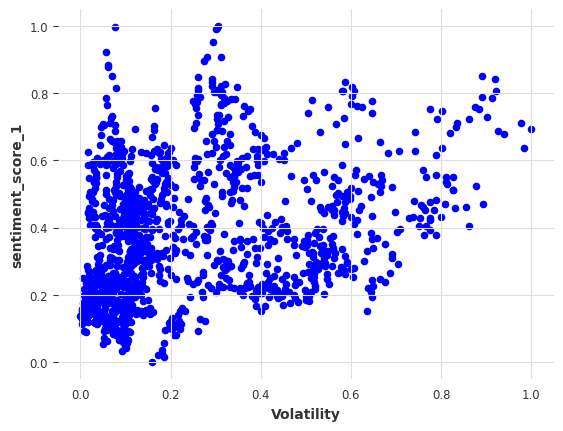

In [27]:
df_scaled.plot.scatter(x='Volatility', y='sentiment_score_1', c='b');

## Google

In [28]:
df = comparison('GOOGL')
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [49]:
print(df[['Close', 'Volume', 'Volatility', 'sentiment_score_1']].rename(columns={
    'sentiment_score_1': 'Sentiment score'
}).corr().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     Close &    Volume &  Volatility &  Sentiment score \\
\midrule
Close           &  1.000000 &  0.213924 &    0.720424 &         0.394209 \\
Volume          &  0.213924 &  1.000000 &    0.727201 &         0.469738 \\
Volatility      &  0.720424 &  0.727201 &    1.000000 &         0.571767 \\
Sentiment score &  0.394209 &  0.469738 &    0.571767 &         1.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_47218/4848927.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  }).corr().to_latex())


In [30]:
df.corr()

,Close,Volume,sentiment_score_1,sentiment_score_2,Volatility
Close,1.000000,-0.360573,0.439749,0.421448,0.591806
Volume,-0.360573,1.000000,0.051329,0.062065,0.315195
sentiment_score_1,0.439749,0.051329,1.000000,0.993664,0.592164
sentiment_score_2,0.421448,0.062065,0.993664,1.000000,0.603571
Volatility,0.591806,0.315195,0.592164,0.603571,1.000000


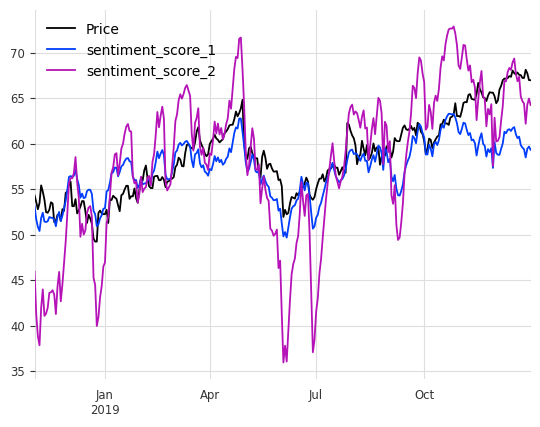

In [31]:
df.Close[1000:].plot(label='Price')
((1 - (df.sentiment_score_1[1000:])) * 80).plot(label='sentiment_score_1')
((1 - (df.sentiment_score_2[1000:])) * 100).plot(label='sentiment_score_2')
plt.legend();

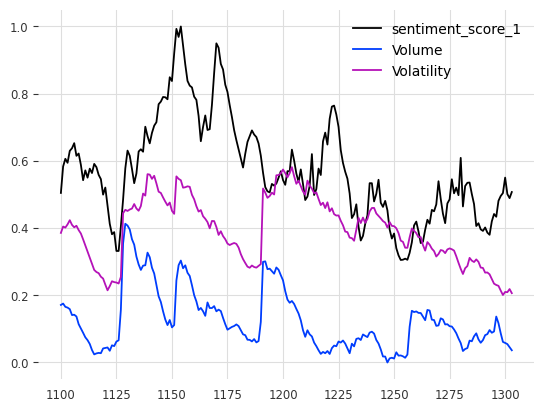

In [32]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][1100:].plot();

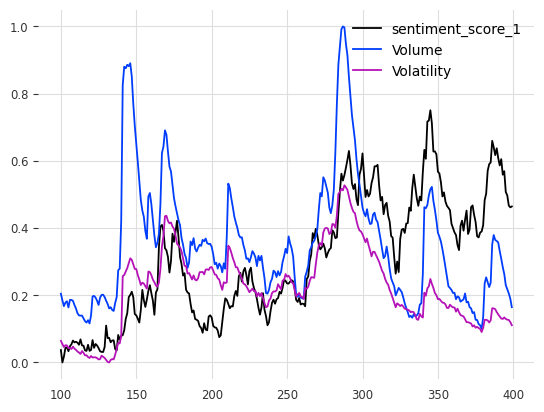

In [33]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][100:400].plot();

/home/andrei/miniconda3/envs/hse/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


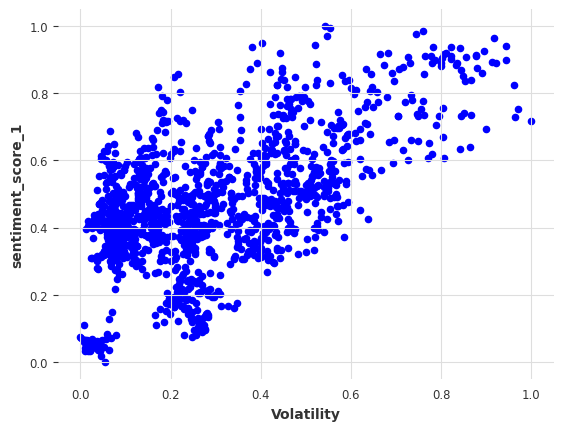

In [34]:
df_scaled.plot.scatter(x='Volatility', y='sentiment_score_1', c='b');

## Tesla

In [35]:
df = comparison('TSLA')
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [36]:
df.corr()

,Close,Volume,sentiment_score_1,sentiment_score_2,Volatility
Close,1.000000,0.369143,0.169956,0.143327,0.572348
Volume,0.369143,1.000000,0.672847,0.672232,0.710637
sentiment_score_1,0.169956,0.672847,1.000000,0.992108,0.582080
sentiment_score_2,0.143327,0.672232,0.992108,1.000000,0.585542
Volatility,0.572348,0.710637,0.582080,0.585542,1.000000


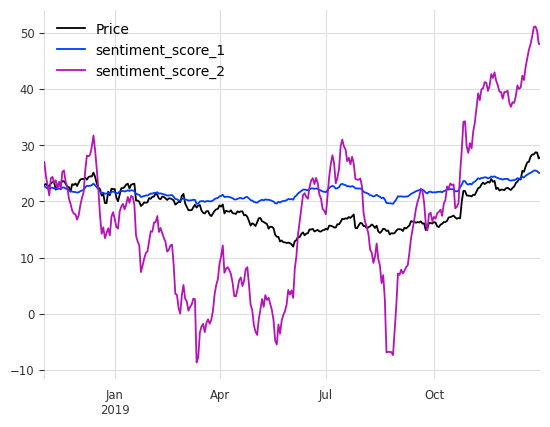

In [37]:
df.Close[1000:].plot(label='Price')
((1 - (df.sentiment_score_1[1000:])) * 40).plot(label='sentiment_score_1')
((1 - (df.sentiment_score_2[1000:])) * 120).plot(label='sentiment_score_2')
plt.legend();

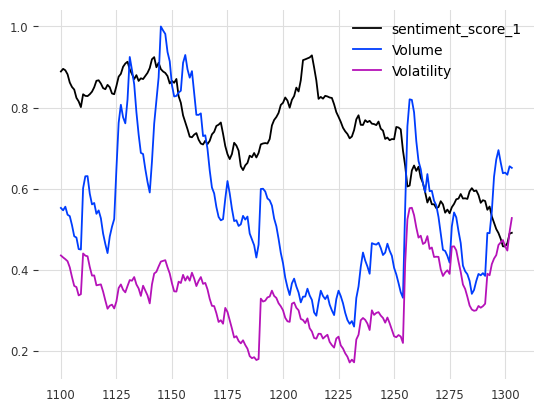

In [38]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][1100:].plot();

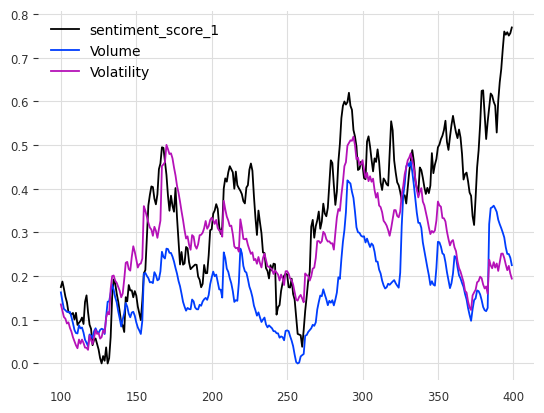

In [39]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][100:400].plot();

/home/andrei/miniconda3/envs/hse/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


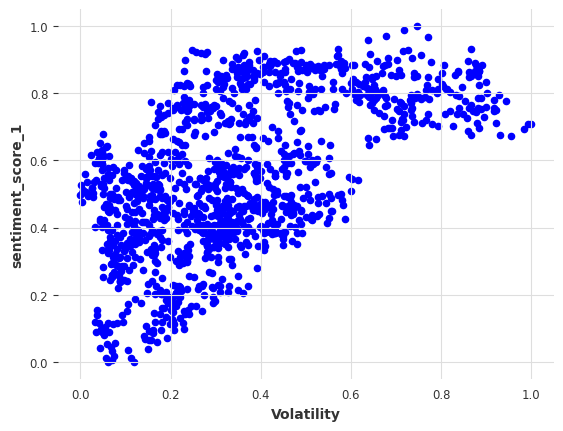

In [40]:
df_scaled.plot.scatter(x='Volatility', y='sentiment_score_1', c='b');

## Amazon

In [41]:
df = comparison('AMZN')
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [42]:
df.corr()

,Close,Volume,sentiment_score_1,sentiment_score_2,Volatility
Close,1.000000,0.213924,0.394209,0.372849,0.720424
Volume,0.213924,1.000000,0.469738,0.482618,0.727201
sentiment_score_1,0.394209,0.469738,1.000000,0.989932,0.571767
sentiment_score_2,0.372849,0.482618,0.989932,1.000000,0.583218
Volatility,0.720424,0.727201,0.571767,0.583218,1.000000


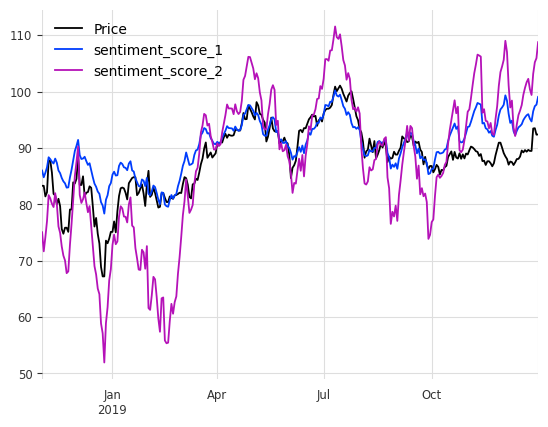

In [43]:
df.Close[1000:].plot(label='Price')
((1 - (df.sentiment_score_1[1000:])) * 130).plot(label='sentiment_score_1')
((1 - (df.sentiment_score_2[1000:])) * 160).plot(label='sentiment_score_2')
plt.legend();

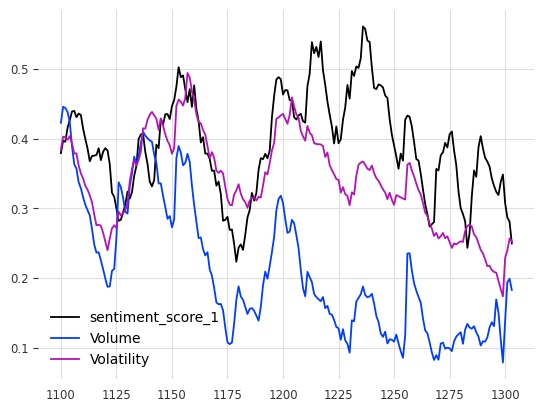

In [44]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][1100:].plot();

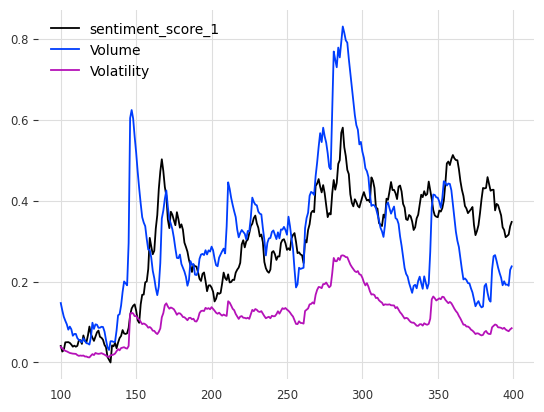

In [45]:
df_scaled[['sentiment_score_1', 'Volume', 'Volatility']][100:400].plot();

/home/andrei/miniconda3/envs/hse/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


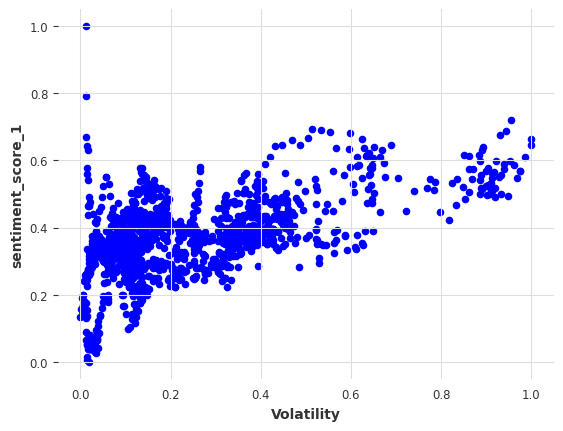

In [46]:
df_scaled.plot.scatter(x='Volatility', y='sentiment_score_1', c='b');